In [1]:
import numpy as np 
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt

import ray

from tools_ryu import mytool
from multi_run_v3.data_pp import DataPreprocess
from multi_run_v3.momentum import make_group_mask
from multi_run_v3.momentum_strategy_decompose import *
from multi_run_v2.initialize_v2 import make_market_index
from multi_run_v3.backtest import simulate_longonly, simulate_longshort

2023-08-15 16:25:41,174	INFO worker.py:1625 -- Started a local Ray instance.


In [2]:
data = pd.read_pickle("Data/cmktcap_data_final.pickle")

days_lst = ["MON","TUE","WED","THU","FRI","SAT","SUN"]

In [3]:
data_pp = DataPreprocess()
data_pp.initialize(data=data)
data_pp.make_mask(mktcap_thresh=1_000_000,
                  vol_thresh=1_000_000,
                  ma=True)

In [4]:
mkt = make_market_index(data_pp.price_df,
                        data_pp.mktcap_df,
                        data_pp.vol_df,
                        1_000_000,
                        1_000_000,
                        True)

In [5]:
# Ray Data 생성
ray_price = ray.put(data_pp.price_df)
ray_mktcap = ray.put(data_pp.mktcap_df)
ray_vol = ray.put(data_pp.vol_df)
ray_daily_rtn = ray.put(data_pp.daily_rtn_df)
ray_weekly_rtn = ray.put(data_pp.weekly_rtn_df)
ray_mask = ray.put(data_pp.mask)

In [6]:
# Terra Luna 제거

#price_pp = cmkt_data["price"].drop("4172", axis=1)
#mktcap_pp = cmkt_data["mktcap"].drop("4172", axis=1)
#vol_pp = cmkt_data["vol"].drop("4172", axis=1)
#ray_price = ray.put(price_pp)
#ray_mktcap = ray.put(mktcap_pp)
#ray_vol = ray.put(vol_pp)

### Value Weighted, Marketcap Capped 

In [13]:
momentum_capped_cmkt = {}

momentum_capped_future = [weekly_momentum_value_weighted_capped.remote(price_df=ray_price,
                                                                       mktcap_df=ray_mktcap,
                                                                       daily_rtn_df = ray_daily_rtn,
                                                                       weekly_rtn_df = ray_weekly_rtn,
                                                                       mask_df = ray_mask,
                                                                       fee_rate = 0.0015,
                                                                       n_group=5,
                                                                       day_of_week=day,
                                                                       num_cap=0.95, # 5% capped
                                                                       margin ='cross',
                                                                       leverage_ratio=2) 
              for day in days_lst]

momentum_capped_result = ray.get(momentum_capped_future)

In [14]:
momentum_result_dict = {"MON":momentum_capped_result[0],
                          "TUE":momentum_capped_result[1],
                          "WED":momentum_capped_result[2],
                          "THU":momentum_capped_result[3],
                          "FRI":momentum_capped_result[4],
                          "SAT":momentum_capped_result[5],
                          "SUN":momentum_capped_result[6]}

In [15]:
import pandas as pd 

def simulate_longshort(long_weight_df:pd.DataFrame, short_weight_df:pd.DataFrame, daily_rtn_df:pd.DataFrame, fee_rate:float, margin:str):
    '''
    전략의 수익을 평가합니다 (long-short Portfolio)
    margin (str) : ["isolate","cross"]

    '''
    pf_value = 1
    pf_dict = {}
    
    # 시작 weight를 지정해준다(첫 weight에서 투자 시작, 장마감 직전에 포트폴리오 구성) / 롱상품, 숏상품 두개의 상품에 투자한다고 가정
    short_weight = short_weight_df.iloc[0]
    long_weight = long_weight_df.iloc[0]  
    
    # 최초 Dollar Value 할당
    dollar_value_of_sell = short_weight * pf_value 
    dollar_value_of_buy = long_weight * pf_value # dollar_value_of_sell - dollar_value_of_buy=0 성립
    
    rebalancing_idx = long_weight_df.index
    start_idx = rebalancing_idx[0]
    
    # 2023-06-18 추가 (weight변화를 기록할 데이터프레임)
    sell_dv_df = pd.Series(index=daily_rtn_df.loc[start_idx:].index)
    long_dv_df = pd.Series(index=daily_rtn_df.loc[start_idx:].index)
    sell_dv_df.loc[start_idx] = 0
    long_dv_df.loc[start_idx] = 0
    
    if margin == 'cross':
        for idx, rtn in daily_rtn_df.loc[start_idx:].iloc[1:].iterrows(): # Daily로 반복, 첫 weight 구성 다음 날부터 성과를 평가
            # 수익률 평가가 리밸런싱보다 선행해야함
            short_rtn = 1 + np.nan_to_num(-rtn) 
            long_rtn  = 1 + np.nan_to_num(rtn) 
            
            # Update each dollar value -> 여기서 개별 코인의 가치가 음수가 되는 일이 생긴다. 그러면 리턴을 곱해주면 음수는 음수가 더 커지는 현상이 발생한다
            # short 상품의 payoff 계산
            short_postive_dv = np.where(dollar_value_of_sell >= 0, dollar_value_of_sell, np.nan) # 양수/음수 DV 분리
            short_negative_dv = np.where(dollar_value_of_sell < 0, dollar_value_of_sell, np.nan) # DV가 음수인 애들
            
            short_postive_dv_gain = (short_postive_dv * short_rtn) - short_postive_dv # 앵수는 그대로 계산
            short_negative_dv_gain = short_negative_dv - (short_negative_dv * short_rtn) # 음수는 그대로 계산
            
            dollar_value_of_sell = dollar_value_of_sell + np.nan_to_num(short_postive_dv_gain) + np.nan_to_num(short_negative_dv_gain)
            
            # Long 상품의 payoff 계산 (똑같은 과정을 통과하면 된다)
            long_positive_dv = np.where(dollar_value_of_buy >= 0, dollar_value_of_buy, np.nan)
            long_negative_dv = np.where(dollar_value_of_buy < 0, dollar_value_of_buy, np.nan)
            
            long_postive_dv_gain = (long_positive_dv * long_rtn) - long_positive_dv 
            long_negative_dv_gain = long_negative_dv - (long_negative_dv * long_rtn)
            
            dollar_value_of_buy = dollar_value_of_buy + np.nan_to_num(long_postive_dv_gain) + np.nan_to_num(long_negative_dv_gain)

            # 포트폴리오 가치 업데이트 (숏 수익 + 롱 수익)
            short_gain = np.nansum(short_postive_dv_gain) + np.nansum(short_negative_dv_gain)
            long_gain = np.nansum(long_postive_dv_gain) + np.nansum(long_negative_dv_gain)
            pf_value = pf_value +  short_gain + long_gain
            
            # 완전히 청산(pf_value 전체가 0이 되는 경우) 끝날떄까지 pf가치는 계속 0이 된다
            if pf_value <= 0:
                pf_value = 0
                dollar_value_of_sell = 0
                dollar_value_of_buy = 0

            sell_dv_df.loc[idx] = short_gain
            long_dv_df.loc[idx] = long_gain

            if idx in rebalancing_idx: # Rebalancing Date (장마감 직전에 리벨런싱 실시)
                long_weight = long_weight_df.loc[idx]   # target weight (리벨런싱할 weight)
                short_weight = short_weight_df.loc[idx]

                target_dollar_value_of_sell = short_weight * pf_value * (1 - fee_rate) # Cash inflow
                target_dollar_value_of_sell = np.where(target_dollar_value_of_sell < 0, 0, target_dollar_value_of_sell) # 2023-07-15 update -> dv가 음수인 애들은 거래비용을 차감하지 않는다
                target_dollar_value_of_buy  = long_weight  * pf_value * (1 - fee_rate)   # Cash outflow  : dollar_value_of_sell+dollar_value_of_buy=0 성립

                dv_delta_sell = np.abs(np.nan_to_num(target_dollar_value_of_sell) - np.nan_to_num(dollar_value_of_sell))
                dv_delta_buy = np.abs(np.nan_to_num(target_dollar_value_of_buy) - np.nan_to_num(dollar_value_of_buy))

                fee = (np.nansum(dv_delta_sell) + np.nansum(dv_delta_buy)) * fee_rate
                pf_value = pf_value - fee # fee 차감

                dollar_value_of_buy  = long_weight  * pf_value  # dollar value를 Rebalancing 이후로 update
                dollar_value_of_sell = short_weight * pf_value

            pf_dict[idx] = pf_value       
            # 2023-06-18추가
                
    # 결과를 pct로 정렬
    pf_result = pd.Series(pf_dict)

    return pf_result, long_dv_df, sell_dv_df

In [16]:
def calculate_statistics(series):
    mean = series.mean()
    std = series.std()
    min_value = series.min()
    max_value = series.max()
    kurt = series.kurt()
    skew = series.skew()
    
    return [mean, std, max_value, min_value, kurt, skew]

In [17]:
pf_dict = {}
long_dict = {}
short_dict = {}

for day, df_list in momentum_result_dict.items():
    long_weight = df_list[-1]
    short_weight = df_list[0]
    
    result_list = simulate_longshort(
                       long_weight_df=long_weight, 
                       short_weight_df=short_weight,
                       daily_rtn_df=data_pp.daily_rtn_df,
                       fee_rate=0.0015,
                       margin='cross')
    
    portfolio_value = result_list[0]
    long_gain = result_list[1].iloc[1:]
    short_gain = result_list[2].iloc[1:]
    
    pf_dict[day] = portfolio_value
    long_dict[day] = long_gain
    short_dict[day] = short_gain
    #long_returns = long_gain / portfolio_value.shift(1)
    #short_returns = short_gain / portfolio_value.shift(1)
    #
    #rt = [calculate_statistics(long_returns), calculate_statistics(short_returns)]
    #
    #p = pd.DataFrame(rt, 
    #         index=['Long', 'Short'],
    #         columns = ['Mean', 'Std','Max', 'Min', 'Kurt','Skew'])
    #result_dict[day] = p

In [18]:
all_pf = (pd.concat(pf_dict.values(), axis=1).fillna(1).sum(1) / 7)
all_long = (pd.concat(long_dict.values(), axis=1).fillna(0).sum(1) / 7)
all_short = (pd.concat(short_dict.values(), axis=1).fillna(0).sum(1) / 7)

In [19]:
long_returns = all_long / all_pf.shift(1)
short_returns = all_short / all_pf.shift(1)

rt = [calculate_statistics(long_returns), calculate_statistics(short_returns)]

p = pd.DataFrame(rt, 
         index=['Long', 'Short'],
         columns = ['Mean', 'Std','Max', 'Min', 'Kurt','Skew'])
p

,Mean,Std,Max,Min,Kurt,Skew
Long,0.002372,0.055795,1.259184,-0.318467,132.567412,5.597476
Short,-0.000233,0.078964,0.442016,-2.527955,537.287921,-16.427204


<AxesSubplot:xlabel='date'>

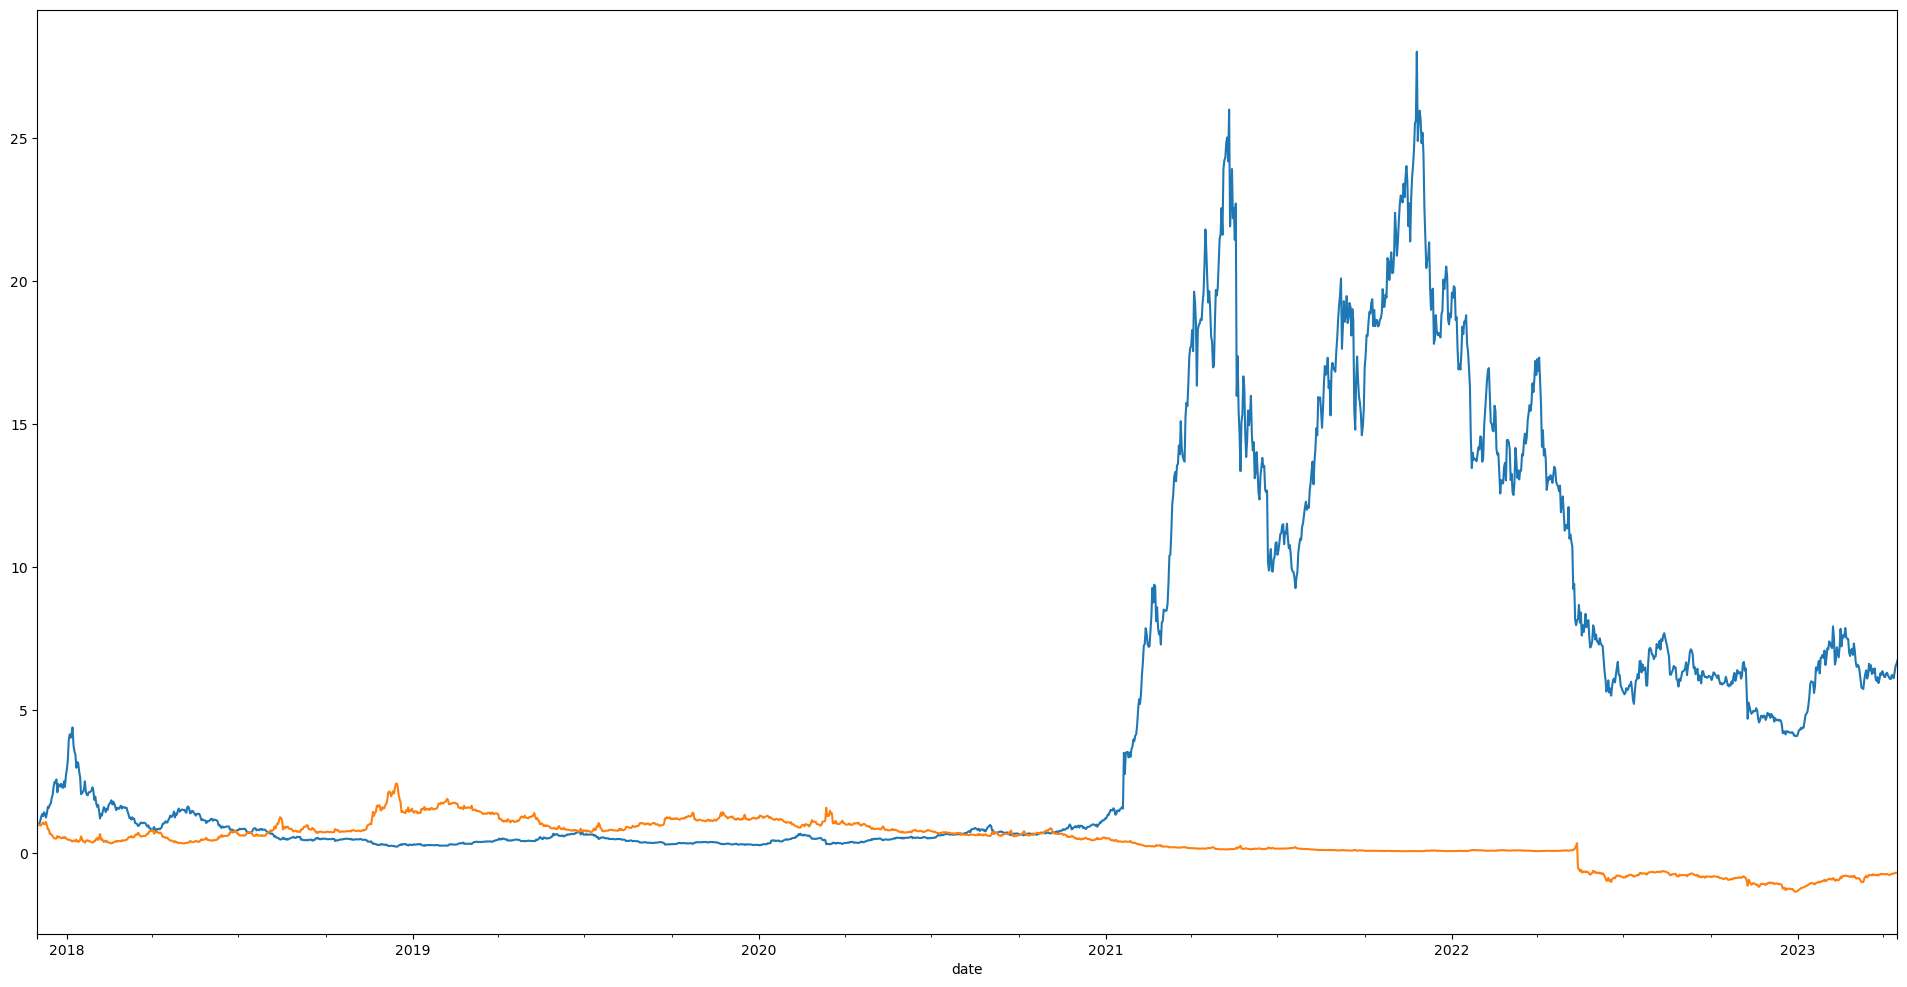

In [24]:
(long_returns.fillna(0) + 1).cumprod().plot(figsize=(24,12))
(short_returns.fillna(0) + 1).cumprod().plot()

Volume_weighted_capped

In [185]:
momentum_capped_cmkt = {}

momentum_capped_future = [weekly_momentum_volume_weighted_capped.remote(price_df=ray_price,
                                                                       mktcap_df=ray_mktcap,
                                                                       vol_df = ray_vol,
                                                                       daily_rtn_df = ray_daily_rtn,
                                                                       weekly_rtn_df = ray_weekly_rtn,
                                                                       mask_df = ray_mask,
                                                                       fee_rate = 0.0015,
                                                                       n_group=5,
                                                                       day_of_week=day,
                                                                       num_cap=0.95, # 5%
                                                                       leverage_ratio=1
                                                                       ) 
              for day in days_lst]

momentum_capped_result = ray.get(momentum_capped_future)

In [186]:
momentum_result_dict_c = {"MON":momentum_capped_result[0],
                          "TUE":momentum_capped_result[1],
                          "WED":momentum_capped_result[2],
                          "THU":momentum_capped_result[3],
                          "FRI":momentum_capped_result[4],
                          "SAT":momentum_capped_result[5],
                          "SUN":momentum_capped_result[6]}

In [187]:
pf_dict = {}
long_dict = {}
short_dict = {}

for day, df_list in momentum_result_dict_c.items():
    long_weight = df_list[-1]
    short_weight = df_list[0]
    
    result_list = simulate_longshort(
                       long_weight_df=long_weight, 
                       short_weight_df=short_weight,
                       daily_rtn_df=data_pp.daily_rtn_df,
                       fee_rate=0.0015,
                       margin='cross')
    
    portfolio_value = result_list[0]
    long_gain = result_list[1].iloc[1:]
    short_gain = result_list[2].iloc[1:]
    
    pf_dict[day] = portfolio_value
    long_dict[day] = long_gain
    short_dict[day] = short_gain

In [188]:
all_pf2 = (pd.concat(pf_dict.values(), axis=1).fillna(1).sum(1) / 7)
all_long2 = (pd.concat(long_dict.values(), axis=1).fillna(0).sum(1) / 7)
all_short2 = (pd.concat(short_dict.values(), axis=1).fillna(0).sum(1) / 7)

In [189]:
long_returns2 = all_long2 / all_pf2.shift(1)
short_returns2 = all_short2 / all_pf2.shift(1)

rt2 = [calculate_statistics(long_returns2), calculate_statistics(short_returns2)]

p2 = pd.DataFrame(rt2, 
         index=['Long', 'Short'],
         columns = ['Mean', 'Std','Max', 'Min', 'Kurt','Skew'])
p2

,Mean,Std,Max,Min,Kurt,Skew
Long,0.000564,0.059389,1.318569,-0.387627,125.491927,5.355937
Short,-0.000073,0.083933,0.485373,-2.627903,491.746016,-15.326439


In [342]:
p

,Mean,Std,Max,Min,Kurt,Skew
Long,0.002372,0.055795,1.259184,-0.318467,132.567412,5.597476
Short,-0.000233,0.078964,0.442016,-2.527955,537.287921,-16.427204


In [219]:
p.Mean * 365, p2.Mean * 365 # short는 6% 차이나는데, long에서의 수익은 66%나 차이가 난다

(Long     0.865644
 Short   -0.085162
 Name: Mean, dtype: float64,
 Long     0.205811
 Short   -0.026531
 Name: Mean, dtype: float64)

### 가설: 잡코인(시총이 작은 코인)일 수록 모멘텀이 적을 것이다

자세하게 말하자면, 잡코인일 수록 모멘텀을 유지하지 못할 것이다 -> 이번주 리턴이 높다고 다음주 리턴이 높지 않을 것이다

In [243]:
momentum_result_dict_c['MON'][4]

coin_id,1,10,100,1000,10005,10006,1001,10011,10016,10023,...,998,9982,9984,9987,9989,999,9991,9996,9997,9998
date,,,,,,,,,,,,,,,,,,,,,
2017-12-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-11,0.154342,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-13,0.036813,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-20,0.038403,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [246]:
val_w = momentum_result_dict['MON'][4]
vol_w = momentum_result_dict_c['MON'][4]

In [306]:
merged_df = pd.DataFrame()

for date, row in vol_w.iterrows():
    row2 = row.dropna().sort_values(ascending=False)
    cum = row2.cumsum()
    mask = cum.loc[cum <= 0.5].index
    
    # Generate dictionary and add it to the merged dictionary
    new = cum.loc[mask].reset_index()
    new.columns = ['coin_id', 'weight']

    merged_df = pd.concat([merged_df, new])

In [317]:
pd.concat([merged_df.coin_id.value_counts().iloc[:20], merged_df2.coin_id.value_counts().iloc[:20]],
          axis=1,
          keys=['volume', 'value'])

,volume,value
coin_id,,
1,52.0,52.0
52,46.0,49.0
1027,44.0,44.0
2,43.0,44.0
1958,40.0,44.0
1765,39.0,31.0
1321,38.0,NaN
1975,37.0,38.0
1839,35.0,43.0


* volume 포폴에만 들어가는거: 1321, 131, 3513, 1437, 6636

* value 포폴에만 들어가는거: 5015, 328, 3957, 7083, 2011

In [349]:
# only value
np.nanmean(data_pp.daily_rtn_df.loc['2017-12':, ['5015','328','3957','7083','2011']].values) * 365

1.4554295573310507

In [347]:
np.nanstd(data_pp.daily_rtn_df.loc['2017-12':, ['5015','328','3957','7083','2011']].values) * 365

38.894850775754286

In [344]:
# only volume 
np.mean(data_pp.daily_rtn_df.loc['2017-12':, ['1321','131','3513','1437','6636']]) * 365

0.7782554336541883

In [350]:
np.nanstd(data_pp.daily_rtn_df.loc['2017-12':, ['1321','131','3513','1437','6636']].values) * 365

24.51436316538812

volume과 리턴의 관계 vs mktcap과 리턴의 관계...